In [5]:
import sys
sys.path.append('../')
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [25]:
def em(y, x_in, px_in, sigma2_in, iter):
    """
    Implements the expectation maximization algorithm for 
    a Gaussian mixture model. y should be a numpy vector
    containing the observed samples. The variables x_in 
    and px_in represent the initial start values for the 
    constellations points and probability distribution, 
    respectively. 'iter' defines the number of iterations.

    A dictionary is returned with the fields 'x', 'px'
    and 'sigma2'.
    """

    N = y.size
    px_out = px_in.reshape((1,px_in.size))
    x_out = x_in.reshape((1,x_in.size))
    sigma2_out = sigma2_in
    
    y = y.reshape((N,1))

    it = 0
    while it < iter:

        # E-Step: calculate the posterior distributions Q_X^i(x) for all samples y_i
        tmp = scipy.stats.norm.pdf(y, loc=x_out, scale=np.sqrt(sigma2_out)) * px_out
        p_xy = tmp / np.sum(tmp, axis=1).reshape((N,1)) # use broadcasting here!

        # M-step: maximization the ELBO over the parameters; the following 
        # equations are the closed form expressions for the hereby obtained
        # stationary points
        px_out = np.sum(p_xy, axis=0)/N
        x_out = np.sum(y * p_xy, axis=0) / np.sum(p_xy, axis=0) # use broadcasting here!
        x_out = x_out.reshape((1,x_out.size))
        sigma2_out = np.mean(np.sum(p_xy * (y - x_out)**2, axis=1)) # use broadcasting here!

        it = it + 1


    data_out = {}
    data_out['x'] = x_out[0,:]
    data_out['px'] = px_out
    data_out['sigma2'] = sigma2_out

    return data_out

In [26]:
def awgn_pY(y, pX, X, sigma2):
    y = y.reshape((y.size,1))
    X = X.reshape((1,X.size))
    pX = pX.reshape((1,pX.size))
    py = np.sum(scipy.stats.norm.pdf(y, loc=X, scale=np.sqrt(sigma2)) * pX, axis=1)

    return py

In [27]:
M = 8
num = 100000
SNRdB = 12
SNR = 10**(SNRdB/10)


X = np.arange(-M+1,M+1,2)
nu = 0.0641 # chosen to get a distribution with a selected entropy of 2.5
pX = np.exp(-nu*X**2)
pX = pX/np.sum(pX)

x = np.random.choice(X, p=pX, size=num)

P = np.mean(x**2)
sigma2 = P/SNR

y = x + np.random.randn(num) * np.sqrt(sigma2)

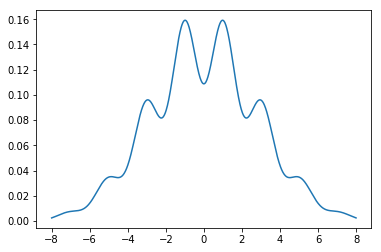

In [28]:
xx = np.linspace(np.min(x)-1, np.max(x)+1, 1000)
real_py = awgn_pY(xx,pX,X,sigma2)
plt.plot(xx, real_py)
plt.show()

In [34]:
params_out = em(y, np.linspace(np.min(y), np.max(y), 8), np.ones((1,8))/8, 1, 30)
print(params_out)

print("Sigma2: {:.3f}".format(params_out['sigma2']))
print("P_X: {:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*params_out['px']))
print("X: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*params_out['x']))

{'x': array([-7.23506927, -5.37338363, -3.20447905, -1.07651741,  1.04564113,
        3.18725733,  5.35818071,  7.20998783]), 'px': array([ 0.00675011,  0.04667554,  0.15773025,  0.28718615,  0.28639821,
        0.16045384,  0.04805276,  0.00675313]), 'sigma2': 0.71213945714788296}
Sigma2: 0.712
P_X: 6.75e-03, 4.67e-02, 1.58e-01, 2.87e-01, 0.29, 0.16, 0.05, 0.01
X: -7.24, -5.37, -3.20, -1.08, 1.05, 3.19, 5.36, 7.21


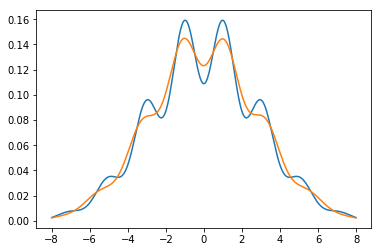

In [35]:
estim_py = awgn_pY(xx,params_out['px'],params_out['x'],params_out['sigma2'])
plt.plot(xx, real_py, xx, estim_py)
plt.show()